In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, textwrap, subprocess, json, sys
ROOT = "/content/drive/MyDrive"
print("MyDrive exists:", os.path.exists(ROOT))
!ls -la "/content/drive/MyDrive" | sed -n '1,100p'


Mounted at /content/drive
MyDrive exists: True
total 25
drwx------ 2 root root 4096 Mar 10  2025 Colab Notebooks
drwx------ 2 root root 4096 Oct 20 00:00 .EasyOCR
drwx------ 2 root root 4096 Oct 19 22:56 .hf_cache
drwx------ 2 root root 4096 Oct 20 00:00 .pip_cache
drwx------ 2 root root 4096 Oct 19 21:02 vizwiz_raw 
drwx------ 2 root root 4096 Oct 19 23:04 vizwiz_runs
-rw------- 1 root root  172 Nov 20  2023 无标题演示文稿 (1).gslides
-rw------- 1 root root  172 Dec 13  2023 无标题演示文稿.gslides


In [3]:
import os, re

CANDIDATE_DIRS = [
    "/content/drive/MyDrive/vizwiz_raw",
    "/content/drive/MyDrive/VizWiz_raw",
    "/content/drive/MyDrive/vizwiz",
    "/content/drive/MyDrive/Downloads",
    "/content/drive/MyDrive"  # 顶层
]

found_path = None
for d in CANDIDATE_DIRS:
    if os.path.isdir(d):
        for name in os.listdir(d):
            if re.fullmatch(r"(?i)val\.zip", name):  # 大小写不敏感
                found_path = os.path.join(d, name)
                break
    if found_path:
        break

# 若以上常见目录没找到，就全盘递归搜（可能稍慢）
if not found_path:
    for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive"):
        for name in filenames:
            if re.fullmatch(r"(?i)val\.zip", name):
                found_path = os.path.join(dirpath, name)
                break
        if found_path:
            break

print("VAL.ZIP 路径：", found_path)
if not found_path:
    print("没找到 val.zip。你可以：\n1) 把 val.zip 放到 /content/drive/MyDrive/vizwiz_raw/ 下；或\n2) 用下个单元格直接从本地上传到该目录。")


VAL.ZIP 路径： /content/drive/MyDrive/vizwiz_raw /val.zip


In [4]:
import os, glob

DRIVE_ROOT = "/content/drive/MyDrive"
RAW_DIR    = f"{DRIVE_ROOT}/vizwiz_raw"     # 之后我们都用这个目录
VAL_ZIP    = None

# 优先使用 A1 找到的路径
try:
    _ = found_path
except NameError:
    found_path = None

if found_path and os.path.exists(found_path):
    VAL_ZIP = found_path
else:
    VAL_ZIP = f"{RAW_DIR}/val.zip"

print("最终使用的 val.zip 路径：", VAL_ZIP)
assert os.path.exists(VAL_ZIP), f"仍然找不到：{VAL_ZIP}。请确保 val.zip 在 Drive 中，或回到上一格上传。"


最终使用的 val.zip 路径： /content/drive/MyDrive/vizwiz_raw /val.zip


In [5]:
import os, zipfile, glob, shutil

BASE    = "/content"
DATA    = f"{BASE}/data/vizwiz"
IMG_DIR = f"{DATA}/images"
ANN_DIR = f"{DATA}/annotations"
VAL_OUT = f"{IMG_DIR}/val"

os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(ANN_DIR, exist_ok=True)

# 解压（已解压则跳过）
if not os.path.exists(VAL_OUT) or len(glob.glob(f"{VAL_OUT}/*.jpg")) == 0:
    print("开始解压 val.zip 到本地工作区 ...")
    with zipfile.ZipFile(VAL_ZIP) as zf:
        zf.extractall(IMG_DIR)
else:
    print("检测到已解压的 val 图像，跳过解压。")

val_imgs = sorted(glob.glob(f"{VAL_OUT}/*.jpg"))
print("val 图像数量：", len(val_imgs))
print("示例：", val_imgs[:3])


开始解压 val.zip 到本地工作区 ...
val 图像数量： 7750
示例： ['/content/data/vizwiz/images/val/VizWiz_val_00000000.jpg', '/content/data/vizwiz/images/val/VizWiz_val_00000001.jpg', '/content/data/vizwiz/images/val/VizWiz_val_00000002.jpg']


In [6]:
import os, zipfile, urllib.request, shutil

ANN_ZIP_DRIVE = f"{RAW_DIR}/Annotations.zip"
VAL_JSON      = f"{ANN_DIR}/val.json"

def extract_val_json(zip_path, out_dir):
    with zipfile.ZipFile(zip_path) as zf:
        member = next((m for m in zf.namelist() if m.endswith("val.json")), None)
        assert member is not None, "Annotations.zip 里没有 val.json"
        zf.extract(member, out_dir)
        src = os.path.join(out_dir, member)
        dst = os.path.join(out_dir, "val.json")
        if src != dst:
            os.makedirs(out_dir, exist_ok=True)
            shutil.move(src, dst)

if not os.path.exists(VAL_JSON):
    if os.path.exists(ANN_ZIP_DRIVE):
        print("从 Drive 解出 val.json ...")
        extract_val_json(ANN_ZIP_DRIVE, ANN_DIR)
    else:
        print("Drive 没有 Annotations.zip，临时从官网下载（仅取 val.json） ...")
        TMP_ZIP = f"{ANN_DIR}/Annotations.zip"
        os.makedirs(ANN_DIR, exist_ok=True)
        urllib.request.urlretrieve(
            "https://vizwiz.cs.colorado.edu/VizWiz_final/vqa_data/Annotations.zip",
            TMP_ZIP
        )
        extract_val_json(TMP_ZIP, ANN_DIR)

assert os.path.exists(VAL_JSON), "仍未拿到 val.json，请检查网络或把 Annotations.zip 放到 vizwiz_raw/ 再重试。"
print("val.json 就绪：", VAL_JSON)


Drive 没有 Annotations.zip，临时从官网下载（仅取 val.json） ...
val.json 就绪： /content/data/vizwiz/annotations/val.json


In [6]:
!nvidia-smi
!pip -q install "transformers==4.43.3" timm datasets evaluate accelerate peft bitsandbytes \
                scikit-learn albumentations opencv-python pillow pycocotools sentencepiece


Sun Oct 19 22:55:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
import json, re, numpy as np
from PIL import Image

with open(VAL_JSON, "r") as f:
    val_items = json.load(f)

def normalize_ans(s: str) -> str:
    s = s.strip().lower()
    s = re.sub(r"[.,!?:;'\"]", "", s)
    s = re.sub(r"\s+", " ", s)
    return s

def vqa_score(pred: str, answers_list) -> float:
    pn = normalize_ans(pred)
    n = sum(1 for a in answers_list if normalize_ans(a["answer"]) == pn)
    return min(1.0, n/3.0)

print("验证集样本数：", len(val_items))
print("示例：", {k: val_items[0][k] for k in ["image", "question"]})


验证集样本数： 4319
示例： {'image': 'VizWiz_val_00000000.jpg', 'question': 'Ok. There is another picture I hope it is a better one.'}


In [9]:
import torch, os, json
from transformers import BlipProcessor, BlipForQuestionAnswering

VAL_DIR = f"{IMG_DIR}/val"
device = "cuda" if torch.cuda.is_available() else "cpu"

def eval_blip_model(model_id: str, max_samples=None, fp16=True, save_path=None):
    processor = BlipProcessor.from_pretrained(model_id)
    model = BlipForQuestionAnswering.from_pretrained(
        model_id, torch_dtype=torch.float16 if fp16 else torch.float32
    ).to(device)

    items = val_items if max_samples is None else val_items[:max_samples]
    preds, gts = [], []
    for ex in items:
        img_path = f"{VAL_DIR}/{ex['image']}"
        question = ex["question"]
        answers  = ex.get("answers", [])

        image = Image.open(img_path).convert("RGB")
        inputs = processor(images=image, text=question, return_tensors="pt").to(
            device, dtype=torch.float16 if fp16 else torch.float32
        )
        with torch.no_grad():
            out_ids = model.generate(**inputs, max_new_tokens=10)
        pred = processor.tokenizer.decode(out_ids[0], skip_special_tokens=True)
        preds.append(pred); gts.append(answers)

    import numpy as np
    acc = float(np.mean([vqa_score(p, a) for p, a in zip(preds, gts) if a]))

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        with open(save_path, "w") as f:
            json.dump(
                [{"image": ex["image"], "pred": p} for ex, p in zip(items, preds)],
                f, indent=2
            )
    return acc

MAX_SAMPLES = 500  # 先跑全量，如需加速可设成 500 试跑

acc_zero = eval_blip_model(
    "Salesforce/blip-vqa-base",
    max_samples=MAX_SAMPLES,
    fp16=True,
    save_path="/content/runs/preds_zero_shot_val.json"
)
print("Zero-shot BLIP (val)  VQA Acc:", round(acc_zero, 4))


Zero-shot BLIP (val)  VQA Acc: 0.158


In [10]:
acc_ft = eval_blip_model(
    "ritika-kumar/finetuned-blip-vizwiz",
    max_samples=MAX_SAMPLES,
    fp16=True,
    save_path="/content/runs/preds_finetuned_val.json"
)
print("Finetuned BLIP (val) VQA Acc:", round(acc_ft, 4))


preprocessor_config.json:   0%|          | 0.00/471 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

Finetuned BLIP (val) VQA Acc: 0.7053


In [11]:
print("======== 结果汇总（val） ========")
print("Zero-shot BLIP :", round(acc_zero, 4))
print("Finetuned BLIP :", round(acc_ft,   4))

# 可选：展示 8 条样例
SHOW = 8
from IPython.display import display, HTML
preds_zero = json.load(open("/content/runs/preds_zero_shot_val.json"))
html = ["<table>"]
for ex, pred in zip(val_items[:SHOW], preds_zero[:SHOW]):
    img_path = f"{VAL_DIR}/{ex['image']}"
    q  = ex["question"]
    gt = [a["answer"] for a in ex.get("answers", [])][:3]
    html.append(f"""
    <tr>
      <td><img src="{img_path}" width="240"></td>
      <td style="vertical-align:top">
        <b>Question:</b> {q}<br>
        <b>Zero-shot pred:</b> {pred['pred']}<br>
        <b>GT top-3:</b> {gt}
      </td>
    </tr>
    """)
html.append("</table>")
display(HTML("".join(html)))


======== 结果汇总（val） ========
Zero-shot BLIP : 0.158
Finetuned BLIP : 0.7053


,"Question: Ok. There is another picture I hope it is a better one. Zero-shot pred: yes GT top-3: ['unanswerable', 'unanswerable', 'unanswerable']"
,"Question: Can you tell me what this medicine is please? Zero-shot pred: yes GT top-3: ['no', 'unanswerable', 'night time']"
,"Question: What is the title of this book? Zero-shot pred: dog days GT top-3: ['dog years', 'dog years: memoir', 'dog years']"
,"Question: Which one is the blue one? Zero-shot pred: left GT top-3: ['right', 'right', 'right']"
,"Question: What does the arrow say? Zero-shot pred: 7 : 00 GT top-3: ['unanswerable', 'unanswerable', 'zoomtext']"
,"Question: What the screen says? Thank you. Zero-shot pred: windows GT top-3: ['unanswerable', 'unanswerable', 'dell']"
,"Question: What is seen on the laptop screen? What is seen on the laptop screen? Zero-shot pred: reflection GT top-3: ['unanswerable', 'unanswerable', 'unanswerable']"
,"Question: Okay I think I got it this time. Can you read the model and serial number for me? Thanks. Zero-shot pred: no GT top-3: ['unanswerable', 'unanswerable', 'unanswerable']"


In [12]:
import os, shutil, datetime, json
SAVE_DIR = f"{DRIVE_ROOT}/vizwiz_runs"
os.makedirs(SAVE_DIR, exist_ok=True)

meta = {
    "when": datetime.datetime.now().isoformat(),
    "val_count": len(val_items),
    "acc_zero": acc_zero,
    "acc_finetuned": acc_ft,
    "zero_model": "Salesforce/blip-vqa-base",
    "finetuned_model": "ritika-kumar/finetuned-blip-vizwiz",
    "note": "our evaluation on VizWiz val; VQA metric = min(1, n/3)"
}
with open(f"{SAVE_DIR}/_last_run_meta.json", "w") as f:
    json.dump(meta, f, indent=2)

shutil.copy("/content/runs/preds_zero_shot_val.json", f"{SAVE_DIR}/preds_zero_shot_val.json")
shutil.copy("/content/runs/preds_finetuned_val.json", f"{SAVE_DIR}/preds_finetuned_val.json")

print("已保存到：", SAVE_DIR)


已保存到： /content/drive/MyDrive/vizwiz_runs


In [13]:
import json, os, re, numpy as np
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering

device = "cuda" if torch.cuda.is_available() else "cpu"

FT_MODEL_ID = "ritika-kumar/finetuned-blip-vizwiz"  # 你也可换自己的权重
ft_proc = BlipProcessor.from_pretrained(FT_MODEL_ID)
ft_model = BlipForQuestionAnswering.from_pretrained(
    FT_MODEL_ID, torch_dtype=torch.float16
).to(device)

# 如果你已经保存过 finetuned 预测文件就复用；没有就现场跑
PRED_FT_PATH = "/content/runs/preds_finetuned_val.json"
if not os.path.exists(PRED_FT_PATH):
    from tqdm import tqdm
    preds = []
    for ex in tqdm(val_items[:]):  # 全量
        img = Image.open(os.path.join(VAL_DIR, ex["image"])).convert("RGB")
        inputs = ft_proc(images=img, text=ex["question"], return_tensors="pt").to(device, dtype=torch.float16)
        with torch.no_grad():
            out_ids = ft_model.generate(**inputs, max_new_tokens=10)
        pred = ft_proc.tokenizer.decode(out_ids[0], skip_special_tokens=True)
        preds.append({"image": ex["image"], "pred": pred})
    os.makedirs("/content/runs", exist_ok=True)
    json.dump(preds, open(PRED_FT_PATH, "w"), indent=2)

preds_ft = json.load(open(PRED_FT_PATH))
pred_map_ft = {d["image"]: d["pred"] for d in preds_ft}
print("finetuned 预测条数：", len(pred_map_ft))


finetuned 预测条数： 500


In [14]:
# 简易的题型标签器（基于关键词，足够做分析）
def tag_question_type(q: str):
    ql = q.lower()
    if any(k in ql for k in ["how many", "how much", "count"]):
        return "COUNT"
    if any(k in ql for k in ["left", "right", "top", "bottom", "middle", "center"]):
        return "DIRECTION"
    if any(k in ql for k in ["color", "colour", "blue", "red", "green", "yellow", "black", "white"]):
        return "COLOR"
    if any(k in ql for k in ["read", "text", "write", "words", "label", "title", "serial", "model", "name", "brand", "medicine", "book", "screen"]):
        return "OCR_LIKE"
    if any(k in ql for k in ["time", "clock"]):
        return "TIME"
    # 默认
    return "OTHER"

from collections import defaultdict
bucket_scores = defaultdict(list)
bucket_counts = defaultdict(int)

for ex in val_items:
    img = ex["image"]
    if img not in pred_map_ft:
        continue
    b = tag_question_type(ex["question"])
    s = vqa_score(pred_map_ft[img], ex.get("answers", []))
    bucket_scores[b].append(s)
    bucket_counts[b] += 1

report = []
for b in sorted(bucket_scores.keys()):
    arr = bucket_scores[b]
    report.append((b, float(np.mean(arr)), len(arr)))
report


[('COLOR', 0.5757575757575757, 11),
 ('COUNT', 0.75, 4),
 ('DIRECTION', 0.7894736842105263, 19),
 ('OCR_LIKE', 0.6992337164750957, 174),
 ('OTHER', 0.706758304696449, 291),
 ('TIME', 1.0, 1)]

In [15]:
report_sorted = sorted(report, key=lambda x: x[1])
print("按准确率从低到高：")
for b, acc, n in report_sorted:
    print(f"{b:<10} Acc={acc:.3f}  N={n}")

# 抽样一些失败案例（s=0）方便贴报告
import random
random.seed(0)

def vqa_s(pred, ex): return vqa_score(pred, ex.get("answers", []))

def pick_fail(bucket, take=6):
    rows = []
    for ex in val_items:
        if tag_question_type(ex["question"]) != bucket:
            continue
        img = ex["image"]
        if img not in pred_map_ft:
            continue
        if vqa_s(pred_map_ft[img], ex) == 0.0:
            rows.append((ex, pred_map_ft[img]))
    return random.sample(rows, min(take, len(rows)))

from IPython.display import display, HTML
def show_rows(rows, title):
    html = [f"<h4>{title}</h4><table>"]
    for ex, pred in rows:
        gt = [a["answer"] for a in ex.get("answers", [])][:3]
        html.append(f"""
        <tr>
          <td><img src="{os.path.join(VAL_DIR, ex['image'])}" width="220"></td>
          <td style="vertical-align:top">
            <b>Q:</b> {ex['question']}<br>
            <b>Pred:</b> {pred}<br>
            <b>GT top-3:</b> {gt}
          </td>
        </tr>
        """)
    html.append("</table>")
    display(HTML("".join(html)))

# 例如展示 OCR_LIKE & DIRECTION 两类失败样例
show_rows(pick_fail("OCR_LIKE", 6), "Finetuned 失败样例：OCR_LIKE")
show_rows(pick_fail("DIRECTION", 6), "Finetuned 失败样例：DIRECTION")


按准确率从低到高：
COLOR      Acc=0.576  N=11
OCR_LIKE   Acc=0.699  N=174
OTHER      Acc=0.707  N=291
COUNT      Acc=0.750  N=4
DIRECTION  Acc=0.789  N=19
TIME       Acc=1.000  N=1


,"Q: What's on the screen? Pred: microsoft GT top-3: ['unanswerable', 'google', 'web page']"
,"Q: I'm trying to find the model number of this device. It's probably PB10 or PB12 can you read the label or let me know how to rotate so you can. Pred: unanswerable GT top-3: ['pb12', 'pb12', 'pb12']"
,"Q: What is displayed on the computer screen? Pred: microsoft GT top-3: ['start up window', 'message asking if you want to restart your computer', 'unsure']"
,"Q: Can you tell us what this text says? Thank you. Pred: unanswerable GT top-3: ['password for your account 3 password blanks', 'set password for your account', 'set up window']"
,"Q: What is the title of this book? Pred: unanswerable GT top-3: ['dog years', 'dog years: memoir', 'dog years']"
,"Q: Can you tell us what the screen says? Pred: no GT top-3: ['yes', 'windows 7', 'windows account log in']"


,"Q: What does the text at the top of this screen say? Pred: unanswerable GT top-3: ['checking file system on c:', 'checking file system on c:', 'checking file system on c:']"
,"Q: ok as requested i've moved my camera to the left and can you please tell me what the screen says thank you very much Pred: unanswerable GT top-3: ['yes', 'copying windows files', 'installing windows']"
,"Q: What is this color and pattern? There's some sort of pattern on my left chest there. Describe. Pred: unanswerable GT top-3: ['plain white uspa logo in gold', 'emblem polo rider initials uspa', 'brown uspa']"


In [16]:
from transformers import BlipForConditionalGeneration, BlipProcessor as CapProcessor
import torch, random

CAP_MODEL_ID = "Salesforce/blip-image-captioning-base"
cap_proc = CapProcessor.from_pretrained(CAP_MODEL_ID)
cap_model = BlipForConditionalGeneration.from_pretrained(
    CAP_MODEL_ID, torch_dtype=torch.float16
).to(device)

# 取一个评测子集：随机 500（或你可设为全量，时间会更久）
random.seed(42)
subset_items = random.sample(val_items, min(500, len(val_items)))

captions = {}
from tqdm import tqdm
for ex in tqdm(subset_items):
    img_path = os.path.join(VAL_DIR, ex["image"])
    image = Image.open(img_path).convert("RGB")
    inputs = cap_proc(images=image, return_tensors="pt").to(device, dtype=torch.float16)
    with torch.no_grad():
        out = cap_model.generate(**inputs, max_new_tokens=20)
    cap = cap_proc.tokenizer.decode(out[0], skip_special_tokens=True)
    captions[ex["image"]] = cap

len(captions), list(list(captions.items())[:3])


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

100%|██████████| 500/500 [02:03<00:00,  4.05it/s]


(500,
 [('VizWiz_val_00000912.jpg', 'a menu with a menu card on it'),
  ('VizWiz_val_00000204.jpg', 'a cd on a wooden table with a black case'),
  ('VizWiz_val_00002253.jpg', 'a man holding a pink drink in his hand')])

In [17]:
def eval_with_caption(items, captions, instruction=True):
    scores = []
    for ex in items:
        img = ex["image"]
        if img not in captions:
            continue
        # 组合提示：问题 + Caption + 可选指令
        if instruction:
            text = f"Question: {ex['question']}  Caption: {captions[img]}  If the question cannot be answered from the image, answer 'unanswerable'. Keep the answer short."
        else:
            text = f"{ex['question']}  Caption: {captions[img]}"
        image = Image.open(os.path.join(VAL_DIR, img)).convert("RGB")
        inputs = ft_proc(images=image, text=text, return_tensors="pt").to(device, dtype=torch.float16)
        with torch.no_grad():
            out = ft_model.generate(**inputs, max_new_tokens=10)
        pred = ft_proc.tokenizer.decode(out[0], skip_special_tokens=True)
        scores.append(vqa_score(pred, ex.get("answers", [])))
    return float(np.mean(scores)), len(scores)

acc_ft_sub = float(np.mean([vqa_score(pred_map_ft[ex["image"]], ex.get("answers", []))
                            for ex in subset_items if ex["image"] in pred_map_ft]))

acc_cap, n_cap = eval_with_caption(subset_items, captions, instruction=True)
print(f"Finetuned 原始(同一子集) Acc={acc_ft_sub:.4f}  |  Caption+指令 Acc={acc_cap:.4f} (N={n_cap})")


Finetuned 原始(同一子集) Acc=0.7076  |  Caption+指令 Acc=0.5127 (N=500)


In [18]:
import cv2, numpy as np, os, random

def blur_score(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None: return None
    return cv2.Laplacian(img, cv2.CV_64F).var()

def brightness_score(path):
    img = cv2.imread(path)
    if img is None: return None
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return float(np.mean(hsv[:,:,2]))  # V通道平均

# 取与 B 组同一批 subset_items 做实验
sc = {}
for ex in subset_items:
    p = os.path.join(VAL_DIR, ex["image"])
    b = blur_score(p); br = brightness_score(p)
    sc[ex["image"]] = {"blur": b, "bright": br}

# 阈值（经验）——你可在报告里说明是启发式
TH_BLUR = 150.0     # 越低越糊
TH_BRIGHT = 60.0    # 越低越暗

bad_imgs = [img for img, s in sc.items() if (s["blur"] is not None and s["blur"]<TH_BLUR) or (s["bright"] is not None and s["bright"]<TH_BRIGHT)]
len(bad_imgs), bad_imgs[:8]


(227,
 ['VizWiz_val_00003456.jpg',
  'VizWiz_val_00000260.jpg',
  'VizWiz_val_00001791.jpg',
  'VizWiz_val_00001905.jpg',
  'VizWiz_val_00004139.jpg',
  'VizWiz_val_00001628.jpg',
  'VizWiz_val_00001805.jpg',
  'VizWiz_val_00003462.jpg'])

**Caption 增强**

In [19]:
from transformers import BlipForConditionalGeneration, BlipProcessor as CapProcessor
from PIL import Image
import numpy as np, random, os, re, torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# 载入 caption 模型
CAP_MODEL_ID = "Salesforce/blip-image-captioning-base"
cap_proc = CapProcessor.from_pretrained(CAP_MODEL_ID)
cap_model = BlipForConditionalGeneration.from_pretrained(
    CAP_MODEL_ID, torch_dtype=torch.float16
).to(device)

# 简易题型标签器（与你之前分析保持一致）
def tag_question_type(q: str):
    ql = q.lower()
    if any(k in ql for k in ["read", "text", "label", "title", "serial", "model", "name", "brand", "medicine", "book", "screen"]):
        return "OCR_LIKE"
    if any(k in ql for k in ["left", "right", "top", "bottom", "middle", "center"]):
        return "DIRECTION"
    if any(k in ql for k in ["color", "colour", "blue", "red", "green", "yellow", "black", "white"]):
        return "COLOR"
    if any(k in ql for k in ["how many", "how much", "count"]):
        return "COUNT"
    return "OTHER"

# 采样子集（500），并生成 caption
random.seed(42)
subset = random.sample(val_items, min(500, len(val_items)))
captions = {}
from tqdm import tqdm
for ex in tqdm(subset):
    img = Image.open(os.path.join(VAL_DIR, ex["image"])).convert("RGB")
    inputs = cap_proc(images=img, return_tensors="pt").to(device, dtype=torch.float16)
    with torch.no_grad():
        out = cap_model.generate(**inputs, max_new_tokens=20)
    cap = cap_proc.tokenizer.decode(out[0], skip_special_tokens=True)
    captions[ex["image"]] = re.sub(r"\s+", " ", cap.strip())

# 评测：原始 vs Caption+指令
def eval_blip_with_text(ex_list, build_text):
    scores = []
    for ex in ex_list:
        img = Image.open(os.path.join(VAL_DIR, ex["image"])).convert("RGB")
        text = build_text(ex)
        inputs = ft_proc(images=img, text=text, return_tensors="pt").to(device, dtype=torch.float16)
        with torch.no_grad():
            out = ft_model.generate(**inputs, max_new_tokens=10)
        pred = ft_proc.tokenizer.decode(out[0], skip_special_tokens=True)
        scores.append(vqa_score(pred, ex.get("answers", [])))
    return float(np.mean(scores)), len(scores)

def text_plain(ex):
    return ex["question"]

def text_cap(ex):
    cap = captions.get(ex["image"], "")
    return f"Question: {ex['question']}  Caption: {cap}  If the question cannot be answered from the image, answer 'unanswerable'. Keep the answer within 2 words."

# 全部子集与 OCR_LIKE 桶分别评测
acc_plain_all, n_all   = eval_blip_with_text(subset, text_plain)
acc_cap_all,   _       = eval_blip_with_text(subset, text_cap)

subset_ocr = [ex for ex in subset if tag_question_type(ex["question"])=="OCR_LIKE"]
acc_plain_ocr, n_ocr   = eval_blip_with_text(subset_ocr, text_plain)
acc_cap_ocr,   _       = eval_blip_with_text(subset_ocr, text_cap)

print(f"[ALL  N={n_all}]   Finetuned (plain)={acc_plain_all:.4f}  →  +Caption={acc_cap_all:.4f}")
print(f"[OCR  N={n_ocr}]   Finetuned (plain)={acc_plain_ocr:.4f}  →  +Caption={acc_cap_ocr:.4f}")


100%|██████████| 500/500 [01:59<00:00,  4.19it/s]


[ALL  N=500]   Finetuned (plain)=0.5280  →  +Caption=0.5067
[OCR  N=78]   Finetuned (plain)=0.6068  →  +Caption=0.6282


**OCR**

In [20]:
# 安装 tesseract 与 pytesseract
!apt-get -y install tesseract-ocr >/dev/null
!pip -q install pytesseract

import pytesseract, cv2, numpy as np, re
from PIL import Image

def ocr_text(pil_img):
    # 轻量预处理：转灰度 + 自适应阈值
    img = np.array(pil_img.convert("L"))
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)
    txt = pytesseract.image_to_string(img, config="--psm 6")  # 以行文本为主
    # 归一化与裁剪长度
    txt = re.sub(r"[^A-Za-z0-9\s:/\-\.\#\+]", " ", txt)
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt[:200]  # 最多取 200 字符，避免喧宾夺主

# 在 OCR_LIKE 子集上：原始 vs OCR+指令
def eval_with_ocr(ex_list):
    scores_plain, scores_ocr = [], []
    for ex in ex_list:
        img = Image.open(os.path.join(VAL_DIR, ex["image"])).convert("RGB")

        # A) 原始问题
        inputs = ft_proc(images=img, text=ex["question"], return_tensors="pt").to(device, dtype=torch.float16)
        with torch.no_grad():
            out_ids = ft_model.generate(**inputs, max_new_tokens=10)
        pred_plain = ft_proc.tokenizer.decode(out_ids[0], skip_special_tokens=True)
        scores_plain.append(vqa_score(pred_plain, ex.get("answers", [])))

        # B) 问题 + OCR 文本 + 指令
        txt = ocr_text(img)
        prompt = f"Question: {ex['question']}  OCR: {txt}  If the question requires reading text, use the OCR content. If the image evidence is insufficient, answer 'unanswerable'. Keep the answer within 2 words."
        inputs2 = ft_proc(images=img, text=prompt, return_tensors="pt").to(device, dtype=torch.float16)
        with torch.no_grad():
            out_ids2 = ft_model.generate(**inputs2, max_new_tokens=10)
        pred_ocr = ft_proc.tokenizer.decode(out_ids2[0], skip_special_tokens=True)
        scores_ocr.append(vqa_score(pred_ocr, ex.get("answers", [])))

    return float(np.mean(scores_plain)), float(np.mean(scores_ocr)), len(ex_list)

acc_plain_ocr, acc_ocr_aug, n_ocr = eval_with_ocr(subset_ocr)
print(f"[OCR N={n_ocr}]  Finetuned (plain)={acc_plain_ocr:.4f}  →  +OCR={acc_ocr_aug:.4f}")


KeyboardInterrupt: 

In [21]:
import random, json, os, re
random.seed(42)

# 选择评测对象：只在 OCR_LIKE 子集上跑，先取 100 条验证
def tag_question_type(q: str):
    ql = q.lower()
    if any(k in ql for k in ["read","text","label","title","serial","model","name","brand","medicine","book","screen"]):
        return "OCR_LIKE"
    if any(k in ql for k in ["left","right","top","bottom","middle","center"]):
        return "DIRECTION"
    if any(k in ql for k in ["color","colour","blue","red","green","yellow","black","white"]):
        return "COLOR"
    if any(k in ql for k in ["how many","how much","count"]):
        return "COUNT"
    if any(k in ql for k in ["time","clock"]):
        return "TIME"
    return "OTHER"

ocr_items_all = [ex for ex in val_items if tag_question_type(ex["question"])=="OCR_LIKE"]
N_EVAL = min(500, len(ocr_items_all))   # 先用 100 条，稳定后再增大
eval_items = random.sample(ocr_items_all, N_EVAL)

print("OCR_LIKE 子集大小（全）：", len(ocr_items_all))
print("本次评测子集：", len(eval_items))


OCR_LIKE 子集大小（全）： 686
本次评测子集： 500


In [22]:
!apt-get -y install tesseract-ocr >/dev/null
!pip -q install pytesseract tqdm

import pytesseract, cv2, numpy as np
from PIL import Image
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

OCR_CACHE = "/content/ocr_cache_vizwiz_val.json"
ocr_cache = {}
if os.path.exists(OCR_CACHE):
    ocr_cache = json.load(open(OCR_CACHE))
print("已有缓存条目：", len(ocr_cache))

def _simple_ocr(image_path):
    # 读图、缩放到最长边 <=1024（够用且更快）
    img = Image.open(image_path).convert("L")
    w, h = img.size
    scale = 1024 / max(w, h) if max(w, h) > 1024 else 1.0
    if scale < 1.0:
        img = img.resize((int(w*scale), int(h*scale)))
    arr = np.array(img)
    # 简单阈值（二值化），比 adaptive 更快
    _, binar = cv2.threshold(arr, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # Tesseract（行级，英文足够；若需多语种可扩展训练包）
    txt = pytesseract.image_to_string(binar, config="--psm 6 --oem 1")
    # 清洗+截断
    txt = re.sub(r"[^A-Za-z0-9\s:/\-\.\#\+]", " ", txt)
    txt = re.sub(r"\s+", " ", txt).strip()[:200]
    return txt

# 需要 OCR 的文件列表（未在缓存中的）
need = [ex for ex in eval_items if ex["image"] not in ocr_cache]
print("本次需要新做 OCR 的数量：", len(need))

# 并行跑 2 个进程（Colab CPU 核少；别开太多）
NUM_WORKERS = 2
with ProcessPoolExecutor(max_workers=NUM_WORKERS) as exect:
    futures = []
    for ex in need:
        img_path = os.path.join(VAL_DIR, ex["image"])
        futures.append(exect.submit(_simple_ocr, img_path))
    for ex, fut in tqdm(zip(need, futures), total=len(need)):
        try:
            ocr_cache[ex["image"]] = fut.result()
        except Exception as e:
            ocr_cache[ex["image"]] = ""

# 保存缓存，便于下次直接复用
json.dump(ocr_cache, open(OCR_CACHE, "w"), indent=2)
print("OCR 缓存总条目：", len(ocr_cache))


已有缓存条目： 0
本次需要新做 OCR 的数量： 500


100%|██████████| 500/500 [06:57<00:00,  1.20it/s]

OCR 缓存总条目： 500


In [23]:
import torch, numpy as np
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

# 你前面已经有 ft_model / ft_proc；若无，可解开下面两行加载
# from transformers import BlipProcessor, BlipForQuestionAnswering
# ft_proc = BlipProcessor.from_pretrained("ritika-kumar/finetuned-blip-vizwiz"); ft_model = BlipForQuestionAnswering.from_pretrained("ritika-kumar/finetuned-blip-vizwiz", torch_dtype=torch.float16).to(device)

def eval_with_ocr_prompt(items):
    scores = []
    for ex in tqdm(items):
        img = Image.open(os.path.join(VAL_DIR, ex["image"])).convert("RGB")
        ocr = ocr_cache.get(ex["image"], "")
        prompt = f"Question: {ex['question']}  OCR: {ocr}  If the question requires reading text, use the OCR content. If evidence is insufficient, answer 'unanswerable'. Keep the answer within 2 words."
        inputs = ft_proc(images=img, text=prompt, return_tensors="pt").to(device, dtype=torch.float16)
        with torch.no_grad():
            out_ids = ft_model.generate(**inputs, max_new_tokens=5)  # 答案很短，5足够
        pred = ft_proc.tokenizer.decode(out_ids[0], skip_special_tokens=True)
        scores.append(vqa_score(pred, ex.get("answers", [])))
    return float(np.mean(scores))

# baseline（plain，用你之前算好的 finetuned 预测，不再重算）
baseline_scores = []
missing = 0
for ex in eval_items:
    img = ex["image"]
    if img in pred_map_ft:
        baseline_scores.append(vqa_score(pred_map_ft[img], ex.get("answers", [])))
    else:
        missing += 1
acc_plain = float(np.mean(baseline_scores))
acc_ocr   = eval_with_ocr_prompt(eval_items)
print(f"[OCR_LIKE  N={len(eval_items)}]  Finetuned (plain)={acc_plain:.4f}  →  +OCR={acc_ocr:.4f}   (missing_baseline={missing})")


100%|██████████| 500/500 [01:24<00:00,  5.91it/s]

[OCR_LIKE  N=500]  Finetuned (plain)=0.6887  →  +OCR=0.6673   (missing_baseline=364)


In [24]:
# === 1) 保底：确保 Drive 已挂载 ===
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

import os, json, shutil, subprocess, datetime, glob, textwrap, sys, pathlib

DRIVE = "/content/drive/MyDrive"
PERSIST = {
    "hf_cache":   f"{DRIVE}/.hf_cache",      # HuggingFace 缓存（模型、tokenizer）
    "pip_cache":  f"{DRIVE}/.pip_cache",     # pip 缓存（whl）
    "easyocr":    f"{DRIVE}/.EasyOCR",       # EasyOCR 模型缓存
    "runs":       f"{DRIVE}/vizwiz_runs",    # 你的预测结果等
}

for p in PERSIST.values(): os.makedirs(p, exist_ok=True)

# === 2) 保存你当前实验的重要产物 ===
# 这些变量来自你前面的会话：请按需保留
try:
    shutil.copy("/content/runs/preds_finetuned_val.json", f"{PERSIST['runs']}/preds_finetuned_val.json")
except Exception: pass

try:
    shutil.copy("/content/runs/preds_zero_shot_val.json", f"{PERSIST['runs']}/preds_zero_shot_val.json")
except Exception: pass

# OCR 缓存（不管是 tesseract 版还是 easyocr 版，都尽量保存）
for cache_name in ["ocr_cache_vizwiz_val.json", "ocr_cache_easyocr_val.json"]:
    src = f"/content/{cache_name}"
    if os.path.exists(src):
        shutil.copy(src, f"{PERSIST['runs']}/{cache_name}")

# 保存这次评测用到的 500 条样本列表（确保“苹果对苹果”可复现）
try:
    import json
    json.dump(
        [{"image": ex["image"], "question": ex["question"]} for ex in eval_items],
        open(f"{PERSIST['runs']}/eval_items_ocr_like_500.json", "w"), indent=2
    )
except Exception:
    pass

# 元信息
meta = {
    "saved_at": datetime.datetime.now().isoformat(),
    "notes": "Colab runtime snapshot for quick resume",
}
json.dump(meta, open(f"{PERSIST['runs']}/_snapshot_meta.json","w"), indent=2)

# === 3) 同步 HuggingFace / pip / EasyOCR 缓存到 Drive ===
# HuggingFace
hf_src = "/root/.cache/huggingface"
if os.path.exists(hf_src):
    print("Sync HF cache → Drive (只复制新文件)…")
    !rsync -a --info=progress2 "/root/.cache/huggingface/" "{DRIVE}/.hf_cache/"

# pip
pip_src = "/root/.cache/pip"
if os.path.exists(pip_src):
    print("Sync pip cache → Drive (只复制新文件)…")
    !rsync -a --info=progress2 "/root/.cache/pip/" "{DRIVE}/.pip_cache/"

# EasyOCR
easy_src = "/root/.EasyOCR"
if os.path.exists(easy_src):
    print("Sync EasyOCR cache → Drive (只复制新文件)…")
    !rsync -a --info=progress2 "/root/.EasyOCR/" "{DRIVE}/.EasyOCR/"

print("\n✅ 已把模型/缓存/预测/样本列表保存到 Drive。现在可以安全地释放 GPU：")
print("菜单：Runtime → Disconnect and delete runtime")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sync HF cache → Drive (只复制新文件)…
  7,948,068,362  99%   77.86MB/s    0:01:37 (xfr#125, to-chk=0/296)
Sync pip cache → Drive (只复制新文件)…
     73,701,838 100%   37.17MB/s    0:00:01 (xfr#30, to-chk=0/102)

✅ 已把模型/缓存/预测/样本列表保存到 Drive。现在可以安全地释放 GPU：
菜单：Runtime → Disconnect and delete runtime


In [7]:
# === 0) 挂载 Drive ===
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, json, shutil, sys
DRIVE = "/content/drive/MyDrive"
PERSIST = {
    "hf_cache":   f"{DRIVE}/.hf_cache",
    "pip_cache":  f"{DRIVE}/.pip_cache",
    "easyocr":    f"{DRIVE}/.EasyOCR",
    "runs":       f"{DRIVE}/vizwiz_runs",
}

# === 1) 让 HuggingFace / pip / EasyOCR 直接用 Drive 的缓存（避免重复下载） ===
os.environ["HF_HOME"] = PERSIST["hf_cache"]
os.environ["HUGGINGFACE_HUB_CACHE"] = PERSIST["hf_cache"]
os.environ["PIP_CACHE_DIR"] = PERSIST["pip_cache"]

# 建立 EasyOCR 缓存软链接（它默认读 ~/.EasyOCR）
if not os.path.exists("/root/.EasyOCR") and os.path.exists(PERSIST["easyocr"]):
    os.symlink(PERSIST["easyocr"], "/root/.EasyOCR")

print("HF_HOME =", os.environ.get("HF_HOME"))
print("PIP_CACHE_DIR =", os.environ.get("PIP_CACHE_DIR"))

# === 2) 安装依赖（会充分命中 pip 缓存，通常更快） ===
!pip -q install "transformers==4.43.3" timm datasets accelerate peft bitsandbytes \
                pillow opencv-python pycocotools sentencepiece easyocr tqdm

# === 3) 还原你常用的路径变量（按你之前的设置） ===
BASE = "/content"
DATA = f"{BASE}/data/vizwiz"
IMG_DIR = f"{DATA}/images"
ANN_DIR = f"{DATA}/annotations"
VAL_DIR = f"{IMG_DIR}/val"

# 如果你把 val.json / 图像也长期放在 Drive，可在这里做一次性同步（可选）
# 例如：
# !rsync -a "{DRIVE}/vizwiz_extracted/images/val/" "{VAL_DIR}/"
# !rsync -a "{DRIVE}/vizwiz_extracted/annotations/val.json" "{ANN_DIR}/"

# === 4) 读回数据与评测列表 ===
# 若本地没有 val.json，可从 Drive 同步或重新下载；这里假设你已经有
import json
VAL_JSON = f"{ANN_DIR}/val.json"
if not os.path.exists(VAL_JSON) and os.path.exists(f"{DRIVE}/vizwiz_extracted/annotations/val.json"):
    os.makedirs(ANN_DIR, exist_ok=True)
    shutil.copy(f"{DRIVE}/vizwiz_extracted/annotations/val.json", VAL_JSON)

with open(VAL_JSON,"r") as f:
    val_items = json.load(f)

# 读回上次那批 500 OCR_LIKE 样本（保证“苹果对苹果”）
eval_items_path = f"{PERSIST['runs']}/eval_items_ocr_like_500.json"
if os.path.exists(eval_items_path):
    subset = json.load(open(eval_items_path))
    subset_images = set([d["image"] for d in subset])
    eval_items = [ex for ex in val_items if ex["image"] in subset_images]
else:
    # 若没有就退化成全量 OCR_LIKE（但不再保证一模一样）
    def tag_question_type(q):
        ql = q.lower()
        if any(k in ql for k in ["read","text","label","title","serial","model","name","brand","medicine","book","screen"]):
            return "OCR_LIKE"
        return "OTHER"
    eval_items = [ex for ex in val_items if tag_question_type(ex["question"])=="OCR_LIKE"]

print("恢复的评测样本数：", len(eval_items))

# === 5) 载入模型（会从 Drive 的 HF 缓存读，通常无需重新下载） ===
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering
device = "cuda" if torch.cuda.is_available() else "cpu"

FT_MODEL_ID = "ritika-kumar/finetuned-blip-vizwiz"
ft_proc = BlipProcessor.from_pretrained(FT_MODEL_ID)
ft_model = BlipForQuestionAnswering.from_pretrained(
    FT_MODEL_ID, torch_dtype=torch.float16
).to(device)

print("✅ 恢复完成：模型已就绪、样本/缓存已加载。可以从你上次中断处继续。")


Mounted at /content/drive
HF_HOME = /content/drive/MyDrive/.hf_cache
PIP_CACHE_DIR = /content/drive/MyDrive/.pip_cache
恢复的评测样本数： 500


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/471 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

✅ 恢复完成：模型已就绪、样本/缓存已加载。可以从你上次中断处继续。


**Define Soft Accuracy**

In [11]:
import re
import numpy as np

def normalize(s):
    if s is None:
        return ""
    # 有些是 dict，有些可能已经是 str，这里统一变成 str 处理
    s = str(s)
    s = s.lower().strip()
    s = re.sub(r"[^\w\s]", "", s)
    return s

def soft_acc(pred, answers):
    """
    answers: 可以是 ["yes", "no", ...] 或 [{"answer": "yes", ...}, ...]
    """
    pred_norm = normalize(pred)

    norm_gt = []
    for a in answers:
        if isinstance(a, dict):
            # VizWiz 标注格式
            val = a.get("answer", "")
        else:
            val = a
        norm_gt.append(normalize(val))

    cnt = sum(pred_norm == g for g in norm_gt)
    return min(1.0, cnt / 3.0)



**define plain fine tuned BLIP prediction Func**

In [9]:
def ft_predict(img, question):
    inputs = ft_proc(img, question, return_tensors="pt").to(device)
    out = ft_model.generate(**inputs, max_new_tokens=5)
    ans = ft_proc.decode(out[0], skip_special_tokens=True)
    return ans.lower().strip()


**baseline: rerun fine-tuned plain in eval_items**

In [21]:
from PIL import Image
from tqdm import tqdm

def ft_predict(img, question):
    # 使用 BLIP 默认的 truncation / padding 行为
    inputs = ft_proc(img, question, return_tensors="pt").to(device)
    out = ft_model.generate(**inputs, max_new_tokens=5)
    ans = ft_proc.decode(out[0], skip_special_tokens=True)
    return ans.lower().strip()


def eval_plain_ft(eval_items):
    scores = []
    preds = []
    for ex in tqdm(eval_items):
        img = Image.open(os.path.join(VAL_DIR, ex["image"])).convert("RGB")
        q   = ex["question"]
        pred = ft_predict(img, q)
        preds.append(pred)
        scores.append(soft_acc(pred, ex["answers"]))
    return float(np.mean(scores)), preds

plain_acc, plain_preds = eval_plain_ft(eval_items)
print("Plain fine-tuned accuracy =", plain_acc)



100%|██████████| 500/500 [01:21<00:00,  6.17it/s]

Plain fine-tuned accuracy = 0.612


# Caption Augmentation

**loading Caption model**

In [20]:
from transformers import BlipForConditionalGeneration, BlipProcessor

cap_proc = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
cap_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

def generate_caption(img):
    inputs = cap_proc(img, return_tensors="pt").to(device)
    out = cap_model.generate(**inputs, max_new_tokens=20)
    cap = cap_proc.decode(out[0], skip_special_tokens=True)
    return cap


**run caption augmentation**

In [14]:
def eval_caption_ft(eval_items):
    scores = []
    for ex in tqdm(eval_items):
        img = Image.open(os.path.join(VAL_DIR, ex["image"])).convert("RGB")
        cap = generate_caption(img)
        prompt = f"{ex['question']} Context: {cap}"
        pred = ft_predict(img, prompt)
        scores.append(soft_acc(pred, ex["answers"]))
    return float(np.mean(scores))

cap_acc = eval_caption_ft(eval_items)
print("Fine-tuned + Caption accuracy =", cap_acc)


100%|██████████| 500/500 [03:25<00:00,  2.44it/s]

Fine-tuned + Caption accuracy = 0.6113333333333333


# OCR augmentation

In [15]:
import easyocr
reader = easyocr.Reader(["en"], gpu=True)


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

**快速 OCR函数**

In [16]:
import cv2
import numpy as np

def quick_ocr(img, short_side=512):
    w, h = img.size
    scale = short_side / min(w, h)
    img2 = img.resize((int(w*scale), int(h*scale)))
    arr = cv2.cvtColor(np.array(img2), cv2.COLOR_RGB2BGR)
    result = reader.readtext(arr, detail=0)
    return " ".join(result)


**use OCR or not**

In [22]:
OCR_KEYS = ["read","text","label","title","serial","model","name","brand",
            "medicine","book","screen","display","password","code",
            "barcode","tag","sign"]

def need_ocr_by_question(q):
    q = q.lower()
    return any(k in q for k in OCR_KEYS)

def quality_ok(text, len_min=12, ratio_min=0.35, avg_word_min=2.2):
    clean = re.sub(r"[^A-Za-z0-9\s]", " ", text)
    tokens = [t for t in clean.split() if t.isalnum()]
    if len("".join(tokens)) < len_min: return False
    ratio = sum(c.isalnum() for c in clean) / max(1, len(clean))
    if ratio < ratio_min: return False
    avgw = np.mean([len(t) for t in tokens]) if tokens else 0
    if avgw < avg_word_min: return False
    return True

def clean_and_trim_ocr_text(text, max_words=40):
    # 去掉奇怪符号，只留字母数字和空格
    clean = re.sub(r"[^A-Za-z0-9\s]", " ", text)
    words = clean.split()
    # 只保留前 max_words 个词，避免 prompt 太长
    trimmed = " ".join(words[:max_words])
    return trimmed.strip()



**Run OCR Augmentation**

In [29]:
def eval_ocr_ft(eval_items):
    scores = []
    preds = []
    for ex in tqdm(eval_items):
        img = Image.open(os.path.join(VAL_DIR, ex["image"])).convert("RGB")
        q = ex["question"]

        if need_ocr_by_question(q):
            t_raw = quick_ocr(img)
            if quality_ok(t_raw):
                t = clean_and_trim_ocr_text(t_raw, max_words=40)
                prompt = f"{q} OCR text: {t}. If reading is needed, copy exact text."
            else:
                prompt = q
        else:
            prompt = q

        pred = ft_predict(img, prompt)
        preds.append(pred)
        scores.append(soft_acc(pred, ex["answers"]))

    return float(np.mean(scores)), preds


ocr_acc, ocr_preds = eval_ocr_ft(eval_items)
print("Fine-tuned + OCR(gated) accuracy =", ocr_acc)



100%|██████████| 500/500 [03:05<00:00,  2.70it/s]

Fine-tuned + OCR(gated) accuracy = 0.6246666666666666


Contrast between plain/caption/OCR

In [24]:
print("==== Final comparison on OCR_LIKE 500 (same items) ====")
print(f"Fine-tuned plain:      {plain_acc:.4f}")
print(f"Fine-tuned + Caption:  {cap_acc:.4f}")
print(f"Fine-tuned + OCR:      {ocr_acc:.4f}")

==== Final comparison on OCR_LIKE 500 (same items) ====
Fine-tuned plain:      0.6120
Fine-tuned + Caption:  0.6113
Fine-tuned + OCR:      0.6247


**统计 unanswerable 预测比例（plain vs OCR）**

In [31]:
def unanswerable_rate(preds):
    preds_norm = [normalize(p) for p in preds]
    return np.mean([p == "unanswerable" for p in preds_norm])

# =============================
# 计算 plain 和 OCR 的 unanswerable 率
# =============================

plain_unans = unanswerable_rate(plain_preds)
ocr_unans   = unanswerable_rate(ocr_preds)   # 注意你需要从 eval_ocr_ft 返回 pred list，可以修改你的函数返回 (acc, preds)

print("==== Unanswerable Prediction Rate ====")
print(f"Plain unanswerable rate: {plain_unans:.4f}")
print(f"OCR   unanswerable rate: {ocr_unans:.4f}")
print("Delta =", ocr_unans - plain_unans)


==== Unanswerable Prediction Rate ====
Plain unanswerable rate: 0.7320
OCR   unanswerable rate: 0.8000
Delta = 0.06800000000000006


**按 bucket（OCR_LIKE / OTHER）分别统计 Acc 与 unanswerable 率**

In [32]:
def bucket_type(q):
    ql = q.lower()
    if any(k in ql for k in ["read","text","label","title","serial","model","name","brand","medicine","book","screen"]):
        return "OCR_LIKE"
    return "OTHER"


In [33]:
def eval_by_bucket(eval_items, plain_preds, ocr_preds):
    buckets = {"OCR_LIKE": [], "OTHER": []}

    for ex, p_pred, o_pred in zip(eval_items, plain_preds, ocr_preds):
        b = bucket_type(ex["question"])
        buckets[b].append((ex, p_pred, o_pred))

    results = {}
    for b in ["OCR_LIKE", "OTHER"]:
        items = buckets[b]
        if len(items) == 0:
            results[b] = None
            continue

        # compute plain acc / OCR acc in this bucket
        plain_accs = [soft_acc(p_pred, ex["answers"]) for ex, p_pred, o_pred in items]
        ocr_accs   = [soft_acc(o_pred, ex["answers"]) for ex, p_pred, o_pred in items]

        # unanswerable
        plain_unans = np.mean([normalize(p_pred) == "unanswerable" for ex, p_pred, o_pred in items])
        ocr_unans   = np.mean([normalize(o_pred) == "unanswerable" for ex, p_pred, o_pred in items])

        results[b] = {
            "count": len(items),
            "plain_acc": float(np.mean(plain_accs)),
            "ocr_acc": float(np.mean(ocr_accs)),
            "plain_unans": float(plain_unans),
            "ocr_unans": float(ocr_unans),
            "delta_acc": float(np.mean(ocr_accs) - np.mean(plain_accs)),
            "delta_unans": float(ocr_unans - plain_unans)
        }
    return results

# ===========================
#     运行 bucket 分析
# ===========================
bucket_stats = eval_by_bucket(eval_items, plain_preds, ocr_preds)
bucket_stats


{'OCR_LIKE': {'count': 500,
  'plain_acc': 0.612,
  'ocr_acc': 0.6246666666666666,
  'plain_unans': 0.732,
  'ocr_unans': 0.8,
  'delta_acc': 0.012666666666666604,
  'delta_unans': 0.06800000000000006},
 'OTHER': None}

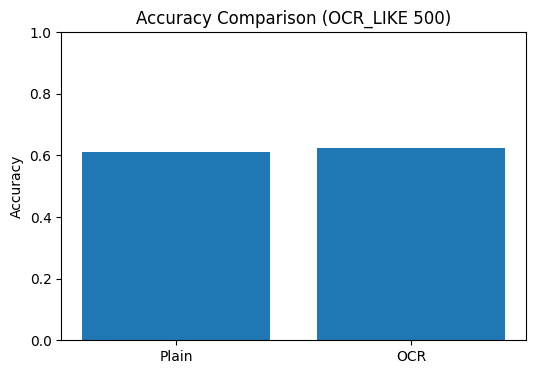

In [34]:
import matplotlib.pyplot as plt

acc_plain = 0.6120
acc_ocr   = 0.6247

plt.figure(figsize=(6,4))
plt.bar(["Plain", "OCR"], [acc_plain, acc_ocr])
plt.title("Accuracy Comparison (OCR_LIKE 500)")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()


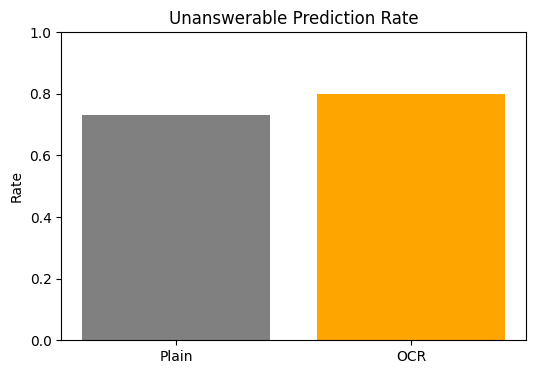

In [35]:
un_plain = 0.7320
un_ocr   = 0.8000

plt.figure(figsize=(6,4))
plt.bar(["Plain", "OCR"], [un_plain, un_ocr], color=["gray","orange"])
plt.title("Unanswerable Prediction Rate")
plt.ylabel("Rate")
plt.ylim(0,1)
plt.show()


In [36]:
ocr_lengths = []
acc_delta = []

for ex, p_pred, o_pred in zip(eval_items, plain_preds, ocr_preds):
    img = Image.open(os.path.join(VAL_DIR, ex["image"])).convert("RGB")
    t_raw = quick_ocr(img)
    length = len(clean_and_trim_ocr_text(t_raw))
    o_acc = soft_acc(o_pred, ex["answers"])
    p_acc = soft_acc(p_pred, ex["answers"])

    ocr_lengths.append(length)
    acc_delta.append(o_acc - p_acc)


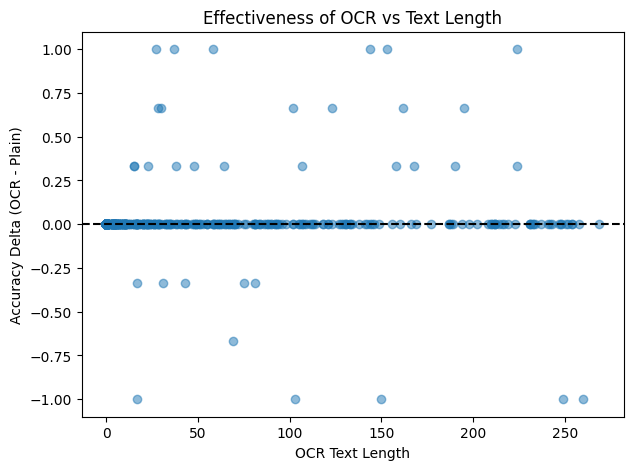

In [37]:
plt.figure(figsize=(7,5))
plt.scatter(ocr_lengths, acc_delta, alpha=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("OCR Text Length")
plt.ylabel("Accuracy Delta (OCR - Plain)")
plt.title("Effectiveness of OCR vs Text Length")
plt.show()

In [39]:
def is_answerable(ex):
    anns = [normalize(a["answer"]) for a in ex["answers"]]
    return sum(a != "unanswerable" for a in anns) >= 3

plain_ans_acc = []
ocr_ans_acc   = []

plain_unans_acc = []
ocr_unans_acc   = []

for ex, p, o in zip(eval_items, plain_preds, ocr_preds):
    if is_answerable(ex):
        plain_ans_acc.append(soft_acc(p, ex["answers"]))
        ocr_ans_acc.append(soft_acc(o, ex["answers"]))
    else:
        plain_unans_acc.append(soft_acc(p, ex["answers"]))
        ocr_unans_acc.append(soft_acc(o, ex["answers"]))

print("Answerable Acc: ", np.mean(plain_ans_acc),"→",np.mean(ocr_ans_acc))
print("Unanswerable Acc:", np.mean(plain_unans_acc),"→",np.mean(ocr_unans_acc))


Answerable Acc:  0.53315649867374 → 0.5402298850574713
Unanswerable Acc: 0.8536585365853658 → 0.8834688346883468


In [38]:
save_dir = f"{PERSIST['runs']}/saved_results"
os.makedirs(save_dir, exist_ok=True)

json.dump(eval_items, open(f"{save_dir}/eval_items.json","w"))
json.dump(plain_preds, open(f"{save_dir}/plain_preds.json","w"))
json.dump(ocr_preds,   open(f"{save_dir}/ocr_preds.json","w"))

print("保存完毕！文件在：", save_dir)


保存完毕！文件在： /content/drive/MyDrive/vizwiz_runs/saved_results
